# <center> **Semiconductor Yield Prediction**</center>
<p style="text-align: right;">By: Vedansh Chauhan</p>

### Contents:
- [Introduction](#welcome)
- [Stage 1: Data Acquisition](#acq)
- [Stage 2: Data Pre-processing](#pre)
- [Stage 3: Exploratory Data Analysis](#eda)
- [Stage 4: Model Building and Training](#build)
- [Stage 5: Model Testing](#test)
- [Conclusion](#bye)

# Introduction <a id="welcome"></a>
Semiconductors are the backbone of modern electronics. Their manufacturing is highly complex, sensitive and expensive. During production, various types of sensors are used to monitor parameters like temperature, pressure etc to ensure quality and consistency of the produce.
However, not all sensor signals are equally useful in predicting the final product's quality. This project aims to analyse the sensor data to identify which sensors are the most relevant for predicting yield outcomes in order to improve efficiency.

#### Project Objective:
Build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.

# Stage 1: DATA ACQUISITION <a id="acq"></a>
#### Objectives:
- Importing the necessary libraries
- Importing the dataset

In [ ]:
#Core Libraries
import pandas as pd
import numpy as np
import pickle

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Modeling
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

### Importing the dataset

In [ ]:
signals = pd.read_csv('/content/signal-data.csv')

In [ ]:
#Overview of the data
signals.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [ ]:
#Number of rows and columns
signals.shape

(1567, 592)

<center><b><h3>DATA DICTIONARY</h3></b></center>

|Serial No.|Column Name|Explanation|
|-|-|-|
| 1 | Time | Shows the time of capturing a signal from a sensor. |
| 2 | '0', ... ,'589' | Each of these columns are individual sensors and represent the signal captured from them.|
| 3 | Pass/Fail | Indicates whether a semiconductor passed or failed the testing process after being manufactured.|

<center>Note: The 'Pass/Fail' is the target/dependent variable.</center>
<center>Where, “–1” corresponds to a pass and “1” corresponds to a fail.</center>

In [ ]:
#Number of sensors in the data (Total columns - the Time and Pass/Fail column)
print(f"There is signal data from {len(signals.columns)-2} sensors (features) in the data.")

There is signal data from 590 sensors (features) in the data.


In [ ]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [ ]:
num_cols = signals.drop(['Time', 'Pass/Fail'], axis=1)

#Null/NaN value inspection
na_values = num_cols.isna()

print(f"There are {na_values.sum().sum()} null values in the data.")

There are 41951 null values in the data.


In [ ]:
#Identifying columns with null values
na_cols = na_values.sum()

#Number of columns with null values
na_cols = na_cols[na_cols > 0].count()

print(f"There are {na_cols} columns with null values.")

There are 538 columns with null values.


In [ ]:
#Identifying rows with null values
na_rows = na_values.any(axis=1).sum()
print(f"There are {na_rows} rows with null values.")

There are 1567 rows with null values.


# Stage 2: DATA PREPROCESSING <a id="pre"></a>
#### Objectives:
- Duplicate Records Elimination
- Imputation: Handling Missing Values
- Feature Engineering
- Train Test Split
- Feature Selection
- Outlier Detection and Elimination
- Skewness Handling
- Feature Scaling
  - Mutual Information
  - Correlation Analysis
- Target Column Balancing
- Dimensionality Reduction

### Duplicate Record Elimination

In [ ]:
print(f"There are {signals.duplicated().sum()} duplicate entries in the data.")

There are 0 duplicate entries in the data.


### Imputation: Handing Missing Values

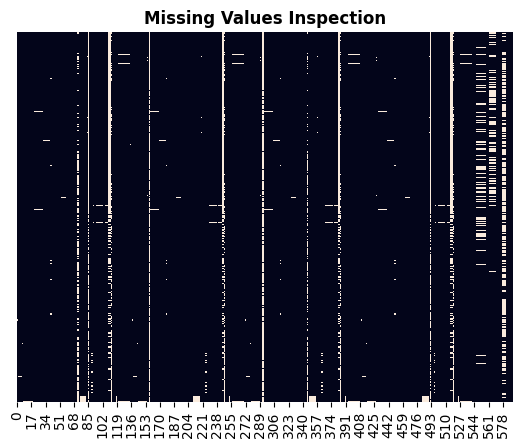

In [ ]:
#Inspecting the missing values in the data visually
sns.heatmap(na_values, yticklabels=False, cbar=False)
plt.title('Missing Values Inspection', fontweight='bold')
plt.show()

#### Observation:
I observe a lot of null/NaN values in various columns.
#### Next Steps:
- In order to decide whether to remove the rows or to impute them, I'll calculate the percentage of the null values in the data.
- If it turns out to be a tiny figure, I'll remove the rows, else I'll proceed to impute them.

In [ ]:
total_rows = signals.shape[0]
percent_nan = (na_rows/total_rows)*100
print(f"Total number of rows in the data: {total_rows}\nNumber of rows with null values: {na_rows}")
print(f"Percentage of null values in the data: {percent_nan:.2f}%")

Total number of rows in the data: 1567
Number of rows with null values: 1567
Percentage of null values in the data: 100.00%


#### Observations:
Well, as per the calculation above, all of the rows contain one or more NaN values.
#### Next Steps:
- I'll now proceed with imputation.
- I'll create a loop to perform the same for each column.
- If a column follows a distribution that is close to Normal (Gaussian), I'll perform **Mean Imputation**.
- If the data is highly skewed, I'll perform **Median Imputation**.

In [ ]:
signals_clean = signals.copy()

for i in num_cols.columns:
    skewness = signals_clean.drop(['Time', 'Pass/Fail'], axis=1)[i].skew()

    if abs(skewness) < 0.5: #Normal distribution or slight skewness
        signals_clean[i] = signals_clean[i].fillna(signals_clean[i].mean())
    else: #Higher Skewness
        signals_clean[i] = signals_clean[i].fillna(signals_clean[i].median())

In [ ]:
#Again inspecting the null values in the data
print(f"There are {signals_clean.isna().sum().sum()} null/NaN values after imputation.")

There are 0 null/NaN values after imputation.


*Null values in the data have been imputed.*

### Feature Engineering
I'll inspect the datatype of the 'Time' attribute and convert into **Unix Timestamp** Unix epoch, which is, seconds since January 1, 1970, at 00:00:00 UTC.

In [ ]:
(signals_clean['Time']).dtype

dtype('O')

*It appears to be a 'Python Object' Datatype.*

In [ ]:
#Converting into Pandas DateTime object for further manipulation
signals_clean['Time'] = pd.to_datetime(signals_clean['Time'])

#Converting into numeric a Unix timestamp
signals_clean['Time'] = pd.to_numeric(signals_clean['Time'])

In [ ]:
(signals_clean['Time']).dtype

dtype('int64')

*The conversion is successful.*

### Train Test Split
I'll now split the data into Training and Testing sets before the future steps to avoid overfitting.

In [ ]:
x_sel = signals_clean.drop('Pass/Fail', axis=1)
y_sel = signals_clean['Pass/Fail']

#Train-test splittling
X_train, X_test, y_train, y_test = train_test_split(x_sel, y_sel, test_size=0.2,
                                                    random_state=15, stratify=y_sel)

*Note: There's no need for a validation set as I shall be using K-fold validation later on.*

### Outlier Detection and Elimination

In [ ]:
X_train.drop('Time', axis=1).describe()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.0,1253.000000,1253.000000,1253.000000,1253.000000,...,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,3013.383432,2497.114710,2200.707960,1401.967408,4.870609,100.0,101.016928,0.121963,1.461238,-0.000731,...,0.004958,81.505593,0.500179,0.015048,0.003794,3.011552,0.021630,0.016389,0.005256,98.759410
std,72.935849,78.885774,29.501385,448.532458,62.726056,0.0,6.209988,0.007953,0.073546,0.015085,...,0.001972,55.875351,0.003349,0.013969,0.003005,2.898641,0.012532,0.008745,0.002866,93.924529
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.047200,...,0.001000,0.000000,0.480000,0.006500,0.001700,1.284500,-0.016900,0.003200,0.001000,0.000000
25%,2966.200000,2453.910000,2180.966600,1084.377900,1.009600,100.0,97.768900,0.121100,1.410800,-0.010600,...,0.004700,72.288900,0.498100,0.011500,0.003100,2.301700,0.013600,0.010500,0.003300,44.175400
50%,3010.300000,2500.050000,2200.733300,1285.214400,1.301500,100.0,101.433300,0.122400,1.460000,-0.001100,...,0.004700,72.288900,0.500300,0.013800,0.003600,2.751200,0.020800,0.014800,0.004600,71.010800
75%,3054.520000,2539.580000,2218.055500,1593.122000,1.512300,100.0,104.415600,0.123800,1.514500,0.008500,...,0.004700,72.288900,0.502400,0.016400,0.004100,3.285500,0.027700,0.020300,0.006400,114.415300
max,3299.400000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,0.028600,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


#### Observations:
- **Centeral Tendency and Magnitude**:
 - The Mean and Median (50th percentile) are close for some attributes, while they differ significantly for others. This suggests that some attributes are moderately skewed, while others are highly skewed.
  - The data includes cases where the Mean is greater than the Median (indicating right/positive skewness) and vice versa (indicating left/negative skewness).
- **Range**: There is significant variation in the minimum and maximum values across different columns, suggesting differences in scales.
- **Dispersion**: The standard deviations for many attributes are close to 0, while for others, they are much higher, indicating varying levels of spread.
*(Magnitude here refers to the difference between the Mean and Median values).*

#### Next Step:
- Given the above scenario, the possibility of outliers is very likely. I'll use **Interquartile Range (IQR)** for capping the possible outliers to the min and max values in their respective columns.
- I'lll exclude the 'Time' attribute as it merely depicts the timestamps.

In [ ]:
X_train_cap = X_train.copy()
X_test_cap = X_test.copy()

#Interquartile Range (IQR)
for col in X_train_cap:

  #Excluding the 'Time' attribute
  if col != 'Time':

    #Calculating IQR
    q1 = X_train_cap[col].quantile(0.25) #Percentile 25
    q3 = X_train_cap[col].quantile(0.75) #Percentile 75
    iqr = q3-q1

    #Setting Outlier Threshold
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    #Capping the Outliers
    X_train_cap[col] = np.clip(X_train_cap[col], lower_bound, upper_bound)
    X_test_cap[col] = np.clip(X_test_cap[col], lower_bound, upper_bound)

*The potential outliers in the various attributes have been capped.*

### Skewness Handling

In [ ]:
def handle_skew(df):
  for col in df:

    #Right Skew
    if skew(df[col]) > 1:
      df[col] = np.log1p(df[col]) #log1p (log(x + 1))

    #Left Skew
    elif skew(df[col]) < -1:
      df[col] = np.log1p(1 / df[col]) #Inverse log1p

    return df

In [ ]:
X_train_skew_hand = handle_skew(X_train_cap)
X_test_skew_hand = handle_skew(X_test_cap)
print("The log transformation process has been successfully completed! ◡̈")

The log transformation process has been successfully completed! ◡̈


### Feature Scaling
Considering that various attributes in the data follow a non-normal distribution and different scales, I'll use **Min-Max Scaling (Normalization)** for scaling.

In [ ]:
#Function for Mxin-Max Scaling (Normalization)
def feat_scaling(train, test):

  #Initialzing the Scaler
  scaler = MinMaxScaler()

  #Fitting the scaler over the training set
  scaler.fit(train)

  #Transforming both, the training and the test sets
  scaler.transform(train)
  scaler.transform(test)

  return train, test

In [ ]:
X_train_scaled = X_train_skew_hand.copy()
X_test_scaled = X_test_skew_hand.copy()

#Applying the function
feat_scaling(X_train_scaled, X_test_scaled)
print("The scaling process has been successfully completed! ◡̈")

The scaling process has been successfully completed! ◡̈


### Feature Selection
I'll use **Mutual information (MI)** for feature selection, a filter method is a non-negative value between two random variables, which measures the dependency between the variables. It's equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [ ]:
#Calculating Mutual Info
X_train_MI = X_train_scaled
mutual_info = mutual_info_classif(X_train_MI, y_train)

In [ ]:
#Converting the resulting array to a Series
mutual_info = pd.Series(mutual_info)

#Setting the index to the names of the features
mutual_info.index = X_train_MI.columns

#Descending order
mutual_info_sorted = mutual_info.sort_values(ascending=False)

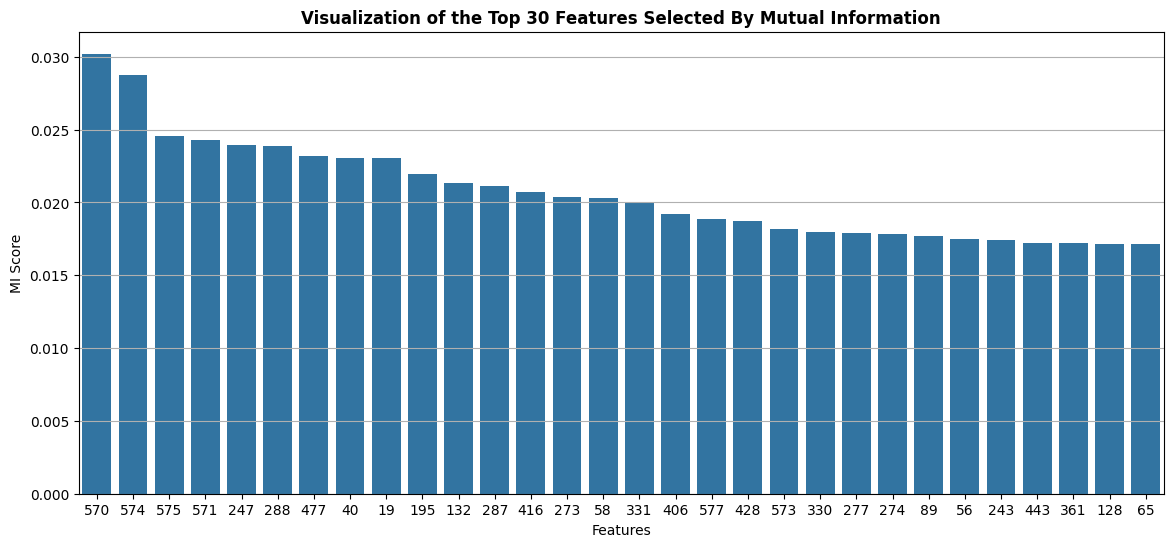

In [ ]:
#Bar Plot
plt.figure(figsize=(14,6))
sns.barplot(mutual_info_sorted.head(30))
plt.title('Visualization of the Top 30 Features Selected By Mutual Information', fontweight='bold')
plt.xlabel('Features')
plt.ylabel('MI Score')
plt.grid(axis='y')
plt.show()

In [ ]:
#Selecting the top 100 features using the SelectKBest class
top_100_feat = mutual_info_sorted.nlargest(100).index #I could use head() as well as I've already sorted the Series above.

#Subsetting the X_train dataframe
X_train_subset = X_train_scaled[top_100_feat]
X_test_subset = X_test_scaled[top_100_feat]

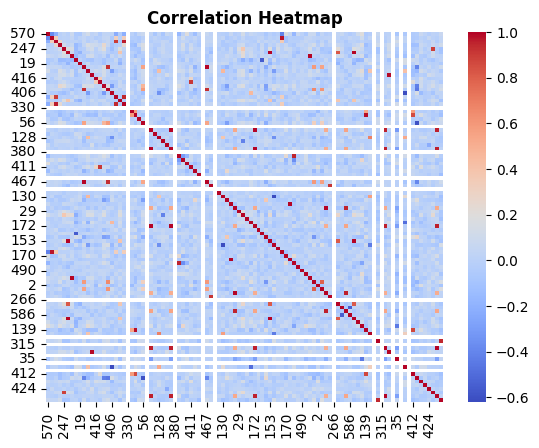

In [ ]:
#Correlation Analysis
sns.heatmap(X_train_subset.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap', fontweight='bold')
plt.show()

#### Observation:
At a glimpse, I observe a lot of columns being highly correlated.
#### Next Step:
I'll use the threshold of 0.9 to remove one out of each pair of highly correlated attributes.

In [ ]:
#A function to eliminate one of every pair of highly correlated attributes
def corr_features(X, thresh):
  col_corr = set() #A 'set' as an output containing names of the correlated attributes
  corr_matrix = X.corr()

  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > thresh:
        col_name = corr_matrix.columns[i]
        col_corr.add(col_name)
  return col_corr

In [ ]:
#Calling the function to detect the highly correlated attributes
corr_cols = corr_features(X_train_subset, 0.9)

In [ ]:
#Viewing the correlated columns
print(corr_cols)

{'425', '426', '205', '331', '172', '583', '407', '467', '310', '309', '577', '173', '308', '307', '174', '573', '576', '153', '411', '139', '377'}


In [ ]:
#Removing one among each pair of highly correlated attributes
X_train_subset = X_train_subset.drop(corr_cols, axis=1)
X_test_subset = X_test_subset.drop(corr_cols, axis=1)
print("The feature selection process has been successfully completed! ◡̈")

The feature selection process has been successfully completed! ◡̈


### Target Balancing
Finally, I'll inspect if the target attribute is imbalanced and try to fix it, if so.

In [ ]:
y_train.value_counts()

,count
Pass/Fail,
-1,1170
1,83


#### Observation:
Class **'1'** is severely under-represented in the data.


I'll use **SMOTE (Synthetic Minority Over-sampling Technique)** to tackle the class inbalance.

In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_subset, y_train)

In [ ]:
y_train_res.value_counts()

,count
Pass/Fail,
-1,1170
1,1170


The Over-sampling process has been successfully completed! ◡̈

### Dimensionality Reduction
I'll use **Principal Component Analysis (PCA)** over the scaled data which is a dimensionality reduction technique that aims to reduce the number of input features while retaining as much of the original information as possible.

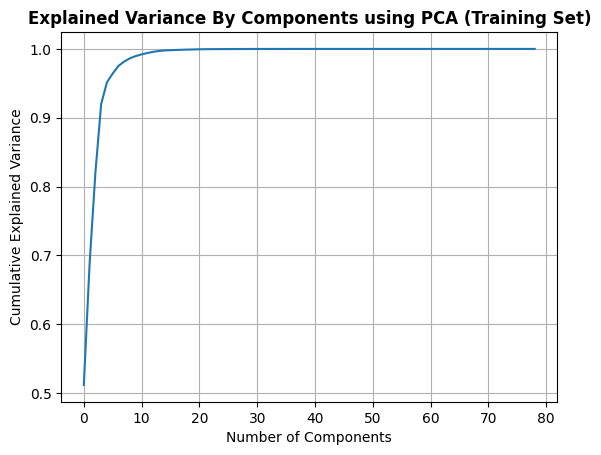

In [ ]:
pca = PCA().fit(X_train_res)

#Plotting the explained variance ratio for each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance By Components using PCA (Training Set)', fontweight='bold')
plt.grid()
plt.show()

#### Observations:
The elbow point corresponds to about 0.96 (96%) of the cumulative explained variance.

In [ ]:
pca = PCA(n_components = 0.96)
pca.fit(X_train_res)
X_train_pca = pca.transform(X_train_res)
X_test_pca = pca.transform(X_test_subset)

The Dimensionality Reduction process has been successfully completed! ◡̈

# Stage 3: EXPLORATORY DATA ANALYSIS (EDA) <a id="section-four"></a>
#### Objective:
- Subsetting the data for visualizations
- Studying the characteristics of the data through:
 - Univariate Analysis
 - Bivariate Analysis
 - Multivariate Analysis

### Subsetting the data for visualizations

In [ ]:
#A new dataframe for visualization to be subsetted
signals_eda = signals.copy()

#A list of the selected attributes
feat_to_keep = list(top_100_feat)

#A list of the correlated attributes
corr_feat = list(corr_cols)

#Adding the 'Time' and the target attribute
feat_to_keep += ['Time', 'Pass/Fail']

#Eliminating the correlated attributes
feat_to_keep = [i for i in feat_to_keep if i not in corr_feat]

In [ ]:
print(f"Number of attributes before subsetting: {signals_eda.shape[1]}")

#Subsetting the data to only keep relavent attributes
signals_eda = signals_eda[feat_to_keep]

print(f"Number of attributes after subsetting: {signals_eda.shape[1]}")

Number of attributes before subsetting: 592
Number of attributes after subsetting: 81


Variable to be used:
- signals_eda

### Studying the characteristics of the data

### Univariate Analysis

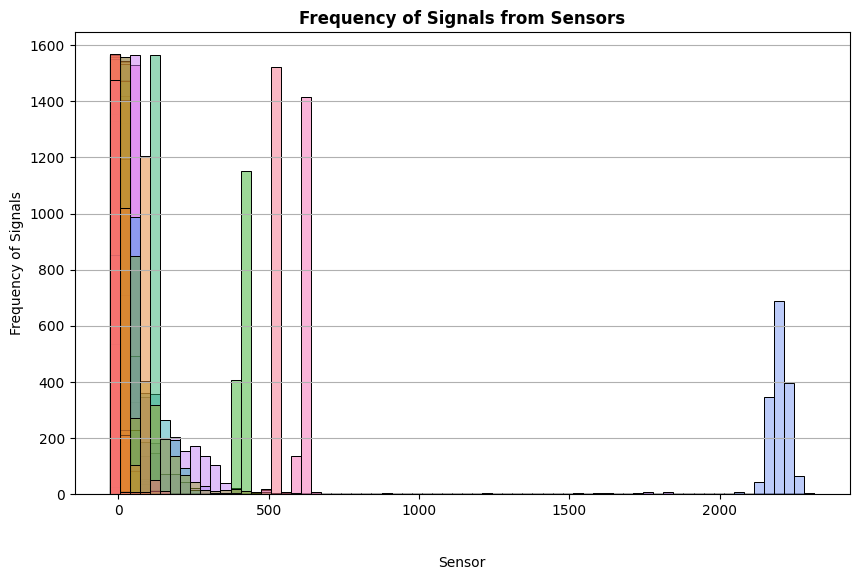

In [ ]:
#Frequency Distribution
plt.figure(figsize=(10,6))
sns.histplot(signals_eda.drop(['Time','Pass/Fail'], axis=1), bins=70, legend=False)
plt.xlabel('\n\nSensor')
plt.ylabel('Frequency of Signals')
plt.title('Frequency of Signals from Sensors', fontweight='bold')
plt.grid(axis='y')
plt.show()

#### Observations:
- Majority of the signals from the sensors indicated values ranging from about -100 to 250 and then somewhere above the 500 mark.
- The signals rarely indicated values from around 550 to 2100.
- Signals also showed values above 2100 quite frequently.

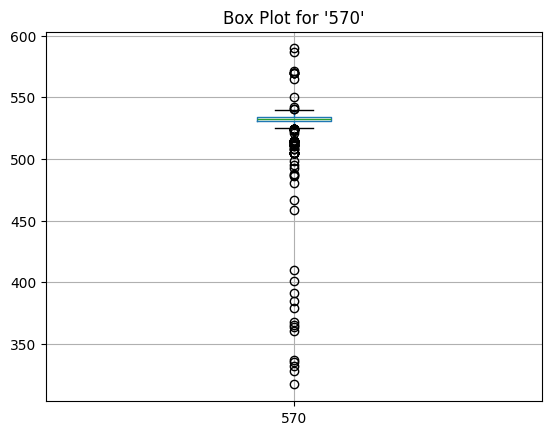

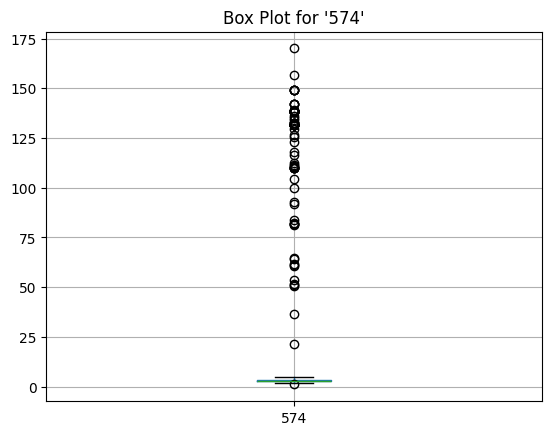

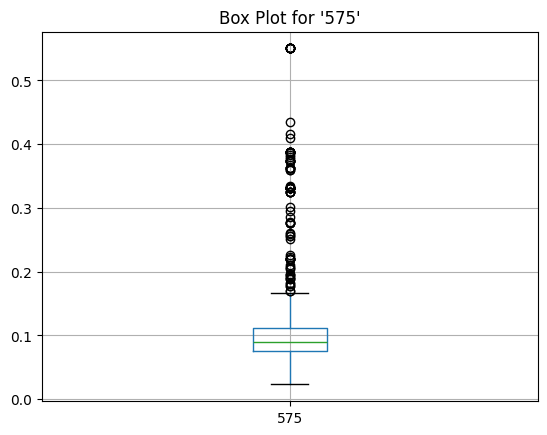

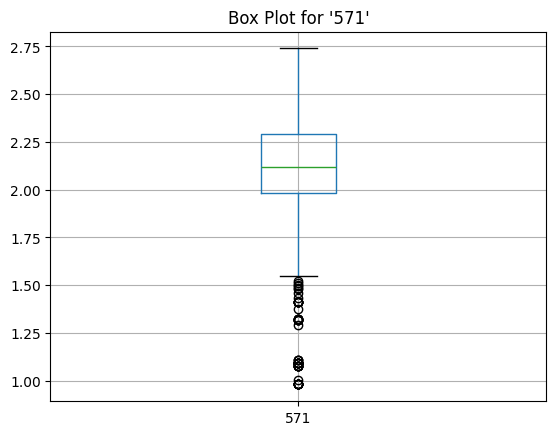

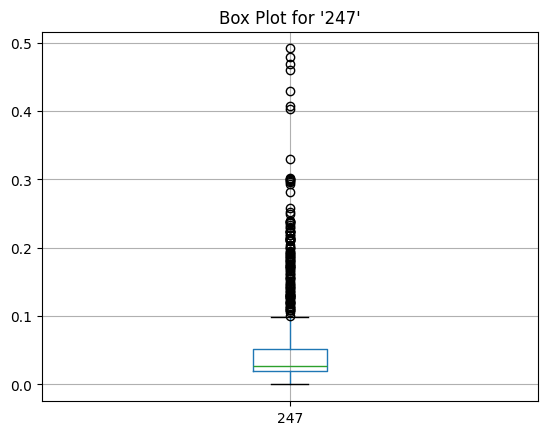

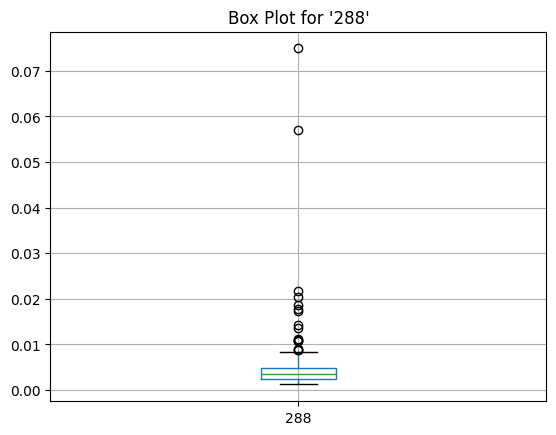

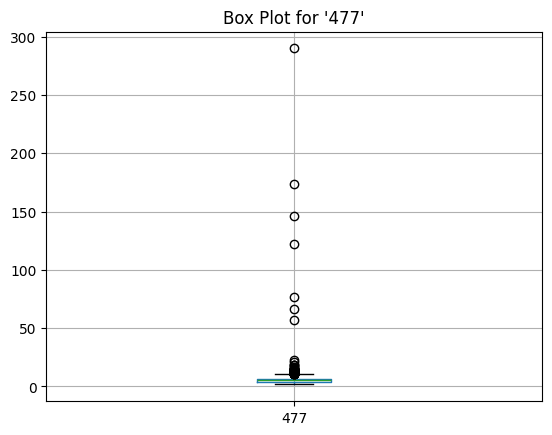

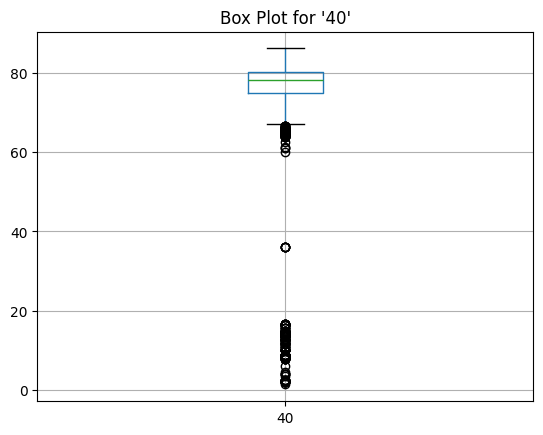

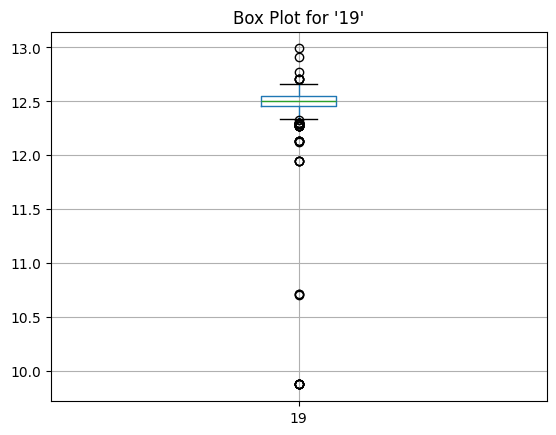

In [ ]:
#Box Plots for the first 10 attributes in the data
for col in signals_eda.columns.drop(['Time','Pass/Fail'])[:9]:
    signals_eda.boxplot(column=col)
    plt.title(f"Box Plot for '{col}'")
    plt.show()

#### Observations:
- Upon observing the first 10 attributes, I observe that most of them contain a lot of outliers.
- The data appears to be skewed due to the median line not being in the center of the box for most of these attributes.
- Sensor 571 appears to have the greatest variability of the signals data while the rest of the sensors appear to have very less variability depicted by the size of the boxes.

### Bivariate Analysis

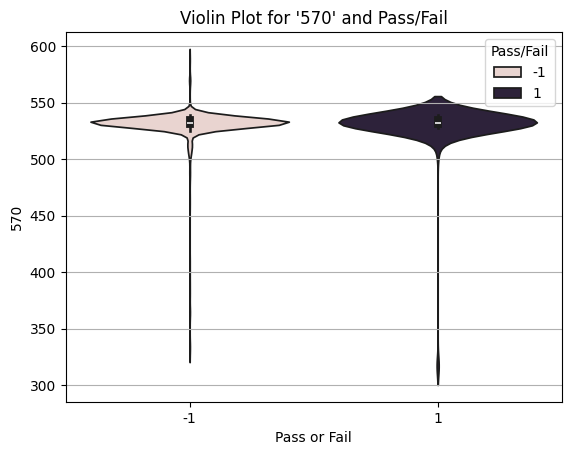

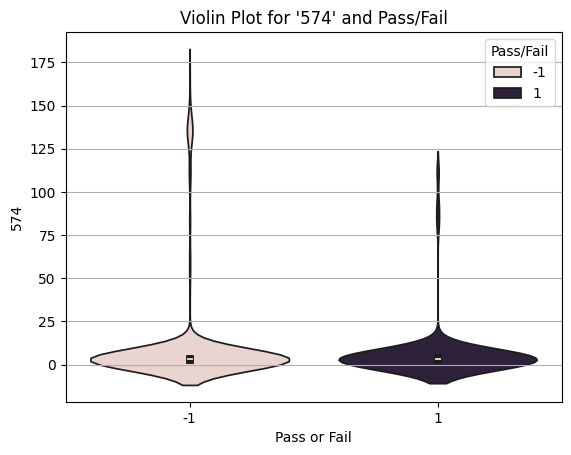

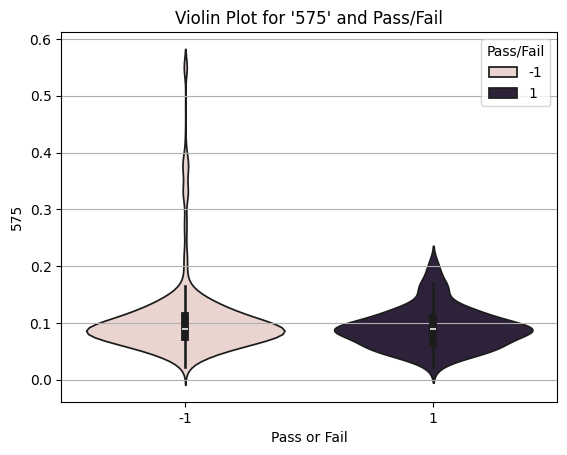

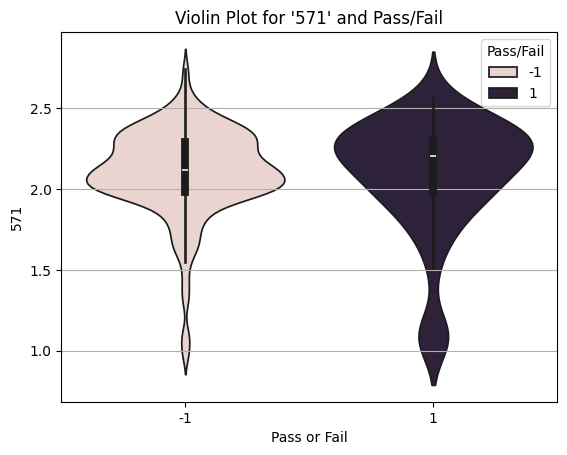

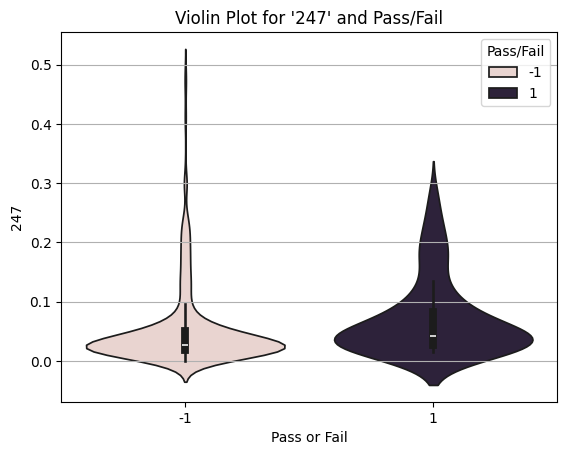

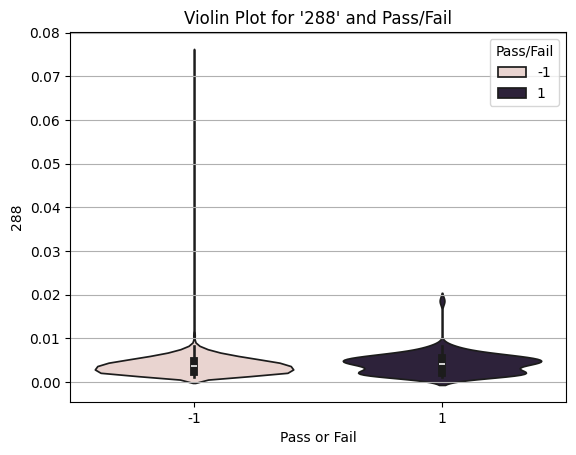

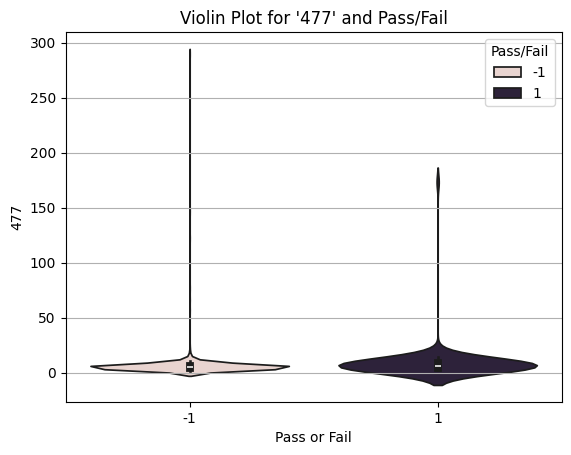

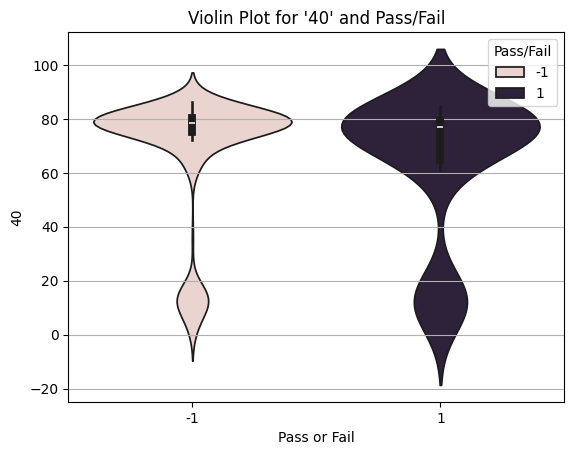

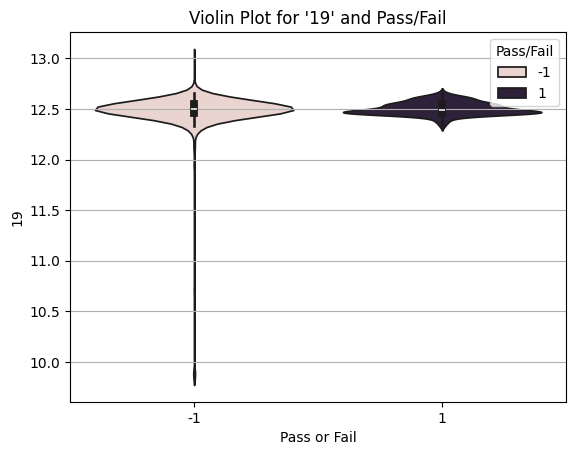

In [ ]:
#Violin Plots
for col in signals_eda.columns[:9]:
    sns.violinplot(x= signals_eda['Pass/Fail'], #x: Categorical variable
                   y=signals_eda[col], #y: Continious variable
                   hue=signals_eda['Pass/Fail'])
    plt.title(f"Violin Plot for '{col}' and Pass/Fail")
    plt.xlabel("Pass or Fail")
    plt.ylabel(col)
    plt.grid(axis='y')
    plt.show()

#### Observations:
- Many of the first 10 attributes appear to have bell shape suggesting a near to normal distrubution while the other depict skewed data.
- Most of these appear to have higher density of signals depicted by the wider width of the plots.
- The wider width of the plots for the '-1' class (Pass class) depicts that the semiconductors passed more often than failing.

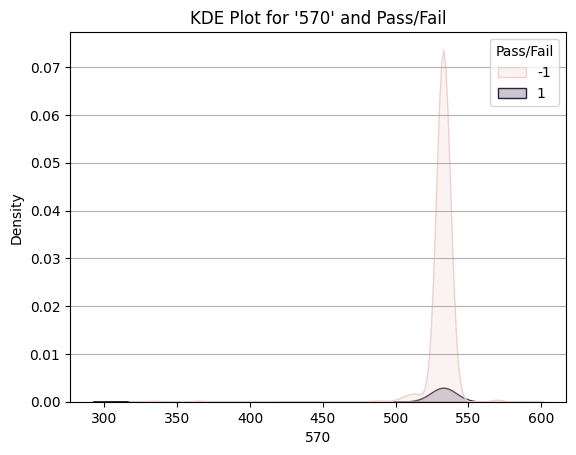

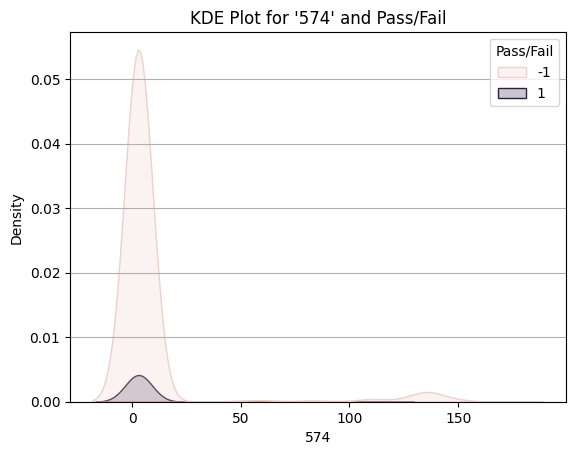

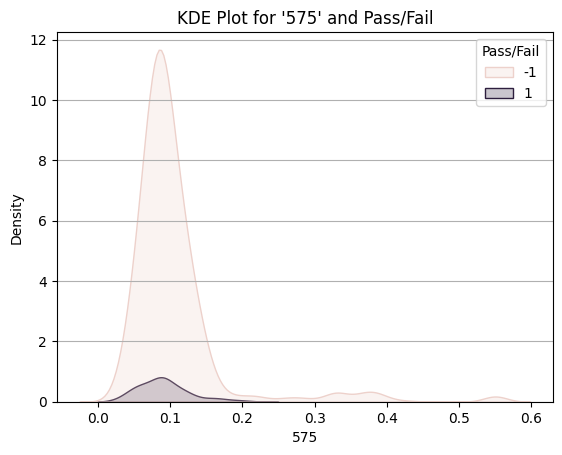

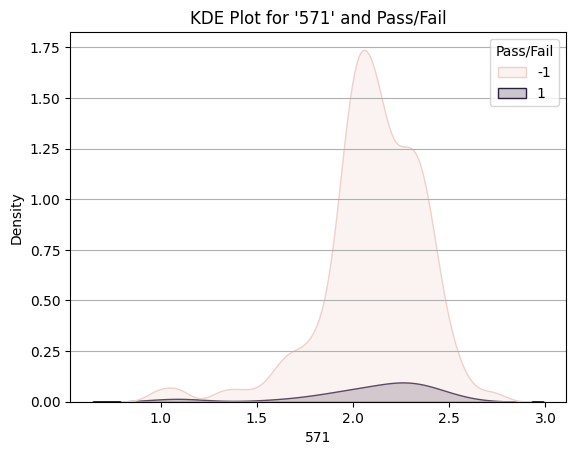

In [ ]:
#Kernel Density Estimate plots
for col in signals_eda.columns[:4]:
    sns.kdeplot(signals_eda, x=col, hue=signals_eda['Pass/Fail'],
                fill=True)
    plt.title(f"KDE Plot for '{col}' and Pass/Fail")
    plt.grid(axis='y')
    plt.show()

#### Observations:
- In all the 5 attributes, the density of the class '-1' (Pass) is much greater indicating a greater likelihood of a semiconductor passing.
- The data for these attributes appear to be skewed.
- The concentrated peaks indicate that the sensors send out a particular range of signals the most.

### Multivariate Analysis

<Figure size 400x400 with 0 Axes>

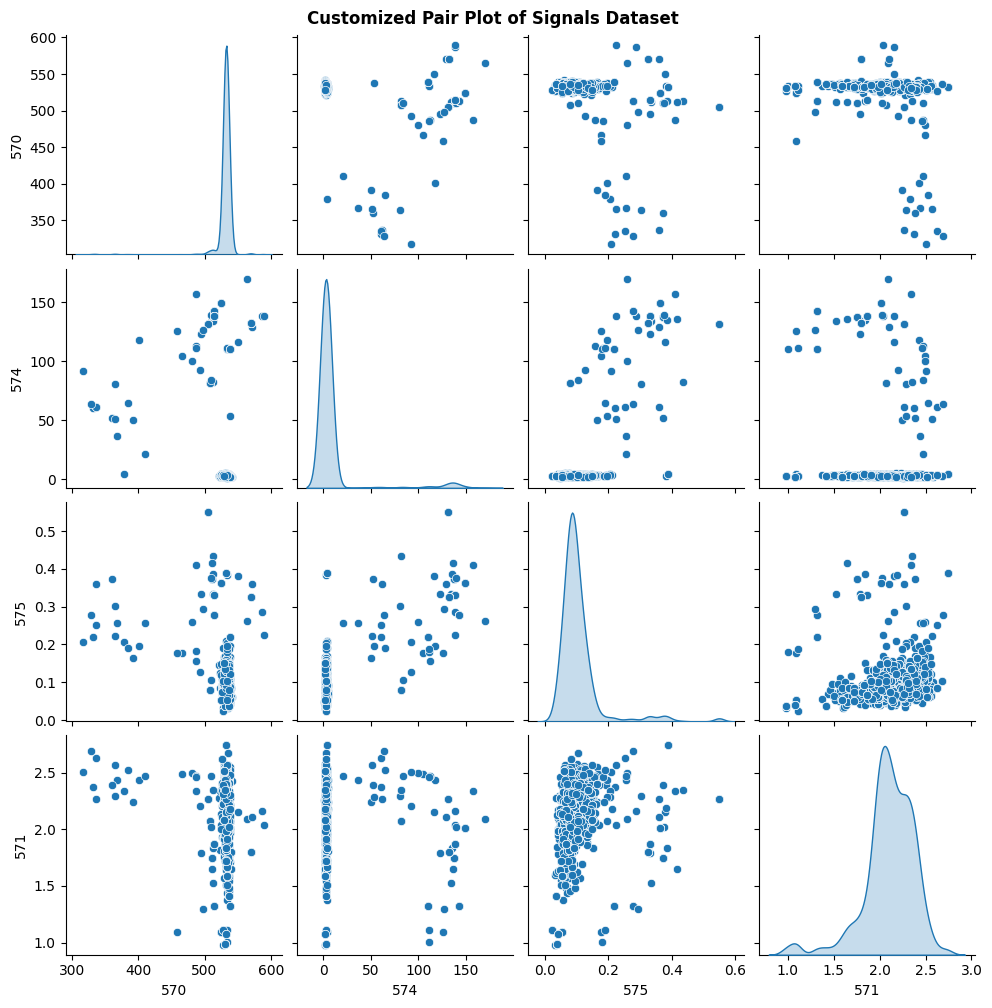

In [ ]:
#Pairplots
cols = signals_eda.columns[:4]

#Pairplots
plt.figure(figsize=(4,4))
sns.pairplot(data=signals_eda, vars=cols, diag_kind='kde',)
plt.suptitle('Customized Pair Plot of Signals Dataset', fontweight='bold', y=1.005)
plt.show()

#### Observations:
- Among the first 4 sensors, '570' and '574', '575' and '574' and '571' and '575' appear the share a non-linear relationship indicated by clusters, while the rest appear closer to sharing a linear relationship.
- While some sensors appear to share a liner relationship, the lines appearing parallel to one of the axes indicate that only one of the variable increases with the increase in the other for the most part.

# Stage 4: MODEL BUILDING AND TRAINING <a id="section-five"></a>
#### Objectives:
- Model Building:
    - Splitting the data into train and validation sets
    - Cross Validation
    - Hyperparameter Tuning
    - Training the model
    - Calculating and setting optimal Threshold values
- Model Evaluation:
    - Confusion Matrix
    - Receiver Operating Characteristic (ROC) Curve
    - Precision Recall Curve

### Model Building
In the sensor signals data, the **positive class represents failure detection**, while the **negative class represents the equipment functioning (pass) class**.

Avoiding a case where failing equipment is incorrectly marked as functioning is crucial. Therefore, my focus will be on minimizing **False Negative (FN) cases.**

Hence, I will prioritize **Recall** as the key evaluation metric.

### Function for Model Building

In [ ]:
#Model building, training and evaluation
def train_eval_model(model, parameters, X, y):
    #Training and validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    #Cross-validation
    cv_rs = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=45)

    #Hyperparameter Tuning
    param_search = GridSearchCV(model, parameters, cv=cv_rs, scoring='recall', n_jobs=-1)

    #Training the model
    param_search.fit(X_train, y_train)
    tuned_model = param_search.best_estimator_
    print(f"Parameters selected by GridSearchCV are:\n{tuned_model}")

    #Predictions
    y_train_pred = tuned_model.predict(X_train)
    y_val_pred = tuned_model.predict(X_val)
    y_val_prob = tuned_model.predict_proba(X_val)[:, 1]

    #Statistical Results for Training Set
    print("\n")
    print("TRAINING SET RESULTS:")
    print("\n")
    print(f"Classification Report:\n{metrics.classification_report(y_train, y_train_pred)}")
    print("." * 55)
    print(f"Accuracy: {metrics.accuracy_score(y_train, y_train_pred):.2f}")
    print(f"Precision: {metrics.precision_score(y_train, y_train_pred):.2f}")
    print(f"Recall: {metrics.recall_score(y_train, y_train_pred):.2f}")
    print(f"F1 Score (Harmonic mean of precision and recall): {metrics.f1_score(y_train, y_train_pred):.2f}")
    print("." * 55)
    print("\n")

    #Statistical Results for Validation Set
    print("VALIDATION SET RESULTS:")
    print("\n")
    print(f"Classification Report:\n{metrics.classification_report(y_val, y_val_pred)}")
    print("." * 55)
    print(f"Accuracy: {metrics.accuracy_score(y_val, y_val_pred):.2f}")
    print(f"Precision: {metrics.precision_score(y_val, y_val_pred):.2f}")
    print(f"Recall: {metrics.recall_score(y_val, y_val_pred):.2f}")
    print(f"F1 Score (Harmonic mean of precision and recall): {metrics.f1_score(y_val, y_val_pred):.2f}")
    print("." * 55)
    print("\n")

    return tuned_model, y_val, y_val_pred, y_val_prob

### Function for Model Evaluation

In [ ]:
#Model evaluation
def evaluate_model(tuned_model, y_val, y_val_pred, y_val_prob):

    #Confusion Matrix
    cm = metrics.confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(5,5))
    cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_plot.plot()
    plt.title(f'Confusion Matrix for {type(tuned_model).__name__}', fontweight='bold')
    plt.show()

    print("." * 55)

    #Receiver Operating Characteristic (ROC) Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_prob)
    roc_auc = metrics.auc(fpr, tpr) ##Calculating Area Under The ROC Curve (AUC)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--') #Reference line
    plt.xlim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {type(tuned_model).__name__}', fontweight='bold')
    plt.legend(loc='best')
    plt.show()
    print("Note for AUC: A higher AUC indicates better performance.")
    '''
    Average recall will provide a balanced evaluation by considering the performance on each class equally.
    '''
    print("." * 55)

    #Calculating Average Recall (AR)
    average_recall = metrics.recall_score(y_val, y_val_pred, average='macro') #Macro-average recall treats each class equally.
    #{Average recall will provide a balanced evaluation by considering the performance on each class equally unlike Accuracy in this case.}

    #Precision-Recall Curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_val_prob)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, color='purple', lw=2, label=f"Precision-Recall curve (Average Recall: {average_recall:.2f})")
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle="--") #Reference Line
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {type(tuned_model).__name__}', fontweight='bold')
    plt.legend(loc='best')
    plt.show()
    print("Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall")

    return None

### Implementing the models
Variables to be used:
- X_train: "X_train_pca"
- y_train: "y_train_res"

##### Logistic Regression Classifier

In [ ]:
lr = LogisticRegression()
lr_params= {
    'max_iter': [1300,1400,1500,1600,1700,1800],
    'penalty': ['l2'],
    'C':[0.0001, 0.001, 0.01, 0.1, 1, 2]
}
tuned_lr, y_val_lr, y_val_pred_lr, y_val_prob_lr = train_eval_model(lr, lr_params, X_train_pca, y_train_res)

Parameters selected by GridSearchCV are:
LogisticRegression(C=0.0001, max_iter=1300)


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.55      0.55      0.55       936
           1       0.55      0.55      0.55       936

    accuracy                           0.55      1872
   macro avg       0.55      0.55      0.55      1872
weighted avg       0.55      0.55      0.55      1872

.......................................................
Accuracy: 0.55
Precision: 0.55
Recall: 0.55
F1 Score (Harmonic mean of precision and recall): 0.55
.......................................................


VALIDATION SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.50      0.52       234
           1       0.53      0.56      0.55       234

    accuracy                           0.53       468
   macro avg       0.53      0.53      0.53       468
weigh

##### K-Nearest Neighbours (KNN) Classifier

In [ ]:
knn =  KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5],
    'metric': ['manhattan'],
    'weights': ['distance', 'uniform']
}
tuned_knn, y_val_knn, y_val_pred_knn, y_val_prob_knn = train_eval_model(knn, knn_params, X_train_pca, y_train_res)

Parameters selected by GridSearchCV are:
KNeighborsClassifier(metric='manhattan', weights='distance')


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       936
           1       1.00      1.00      1.00       936

    accuracy                           1.00      1872
   macro avg       1.00      1.00      1.00      1872
weighted avg       1.00      1.00      1.00      1872

.......................................................
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score (Harmonic mean of precision and recall): 1.00
.......................................................


VALIDATION SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.99      0.66      0.79       234
           1       0.74      1.00      0.85       234

    accuracy                           0.83       468
   macro avg       0.87      0.83      0.8

##### Naive Bayes Classifier

In [ ]:
nb = GaussianNB()
nb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
tuned_nb, y_val_nb, y_val_pred_nb, y_val_prob_nb = train_eval_model(nb, nb_params, X_train_pca, y_train_res)

Parameters selected by GridSearchCV are:
GaussianNB()


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.56      0.59       936
           1       0.60      0.68      0.64       936

    accuracy                           0.62      1872
   macro avg       0.62      0.62      0.62      1872
weighted avg       0.62      0.62      0.62      1872

.......................................................
Accuracy: 0.62
Precision: 0.60
Recall: 0.68
F1 Score (Harmonic mean of precision and recall): 0.64
.......................................................


VALIDATION SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.50      0.56       234
           1       0.59      0.70      0.64       234

    accuracy                           0.60       468
   macro avg       0.61      0.60      0.60       468
weighted avg       0.61      0.60   

##### eXtreme Gradient Boosting Classifier

In [ ]:
y_train_binary = (y_train_res + 1) // 2

xgb = XGBClassifier()
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'random_state': [44],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0]
}
tuned_xgb, y_val_xgb, y_val_pred_xgb, y_val_prob_xgb = train_eval_model(xgb, xgb_params, X_train_pca, y_train_binary)

Parameters selected by GridSearchCV are:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=44, ...)


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       936
           1       1.00      1.00      1.00       

##### Random Forest Classifier (Bagging based)

In [ ]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'random_state': [43],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 3, 12],
    'min_samples_leaf': [1, 2, 4]
}
tuned_rf, y_val_rf, y_val_pred_rf, y_val_prob_rf = train_eval_model(rf, rf_params, X_train_pca, y_train_res)

Parameters selected by GridSearchCV are:
RandomForestClassifier(max_depth=10, n_estimators=50, random_state=43)


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.99      0.81      0.89       936
           1       0.84      0.99      0.91       936

    accuracy                           0.90      1872
   macro avg       0.92      0.90      0.90      1872
weighted avg       0.92      0.90      0.90      1872

.......................................................
Accuracy: 0.90
Precision: 0.84
Recall: 0.99
F1 Score (Harmonic mean of precision and recall): 0.91
.......................................................


VALIDATION SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.70      0.78       234
           1       0.75      0.90      0.82       234

    accuracy                           0.80       468
   macro avg       0.81      0.8

##### Light Gradient Boosting Machine Classifier (Boosting based)

In [ ]:
lgb = LGBMClassifier()
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8, 1.0],
}
tuned_lgb, y_val_lgb, y_val_pred_lgb, y_val_prob_lgb = train_eval_model(lgb, lgb_params, X_train_pca, y_train_res)

[LightGBM] [Info] Number of positive: 936, number of negative: 936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Parameters selected by GridSearchCV are:
LGBMClassifier(n_estimators=200, num_leaves=50, subsample=0.7)


TRAINING SET RESULTS:


Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       936
           1       1.00      1.00      1.00       936

    accuracy                           1.00      1872
   macro avg       1.00      1.00      1.00      1872
weighted avg       1.00      1.00      1.00      1872

.......................................................
Accuracy: 1.00
Precision: 1.00


### Evaluation Metrics

##### Logistic Regression Classifier

<Figure size 500x500 with 0 Axes>

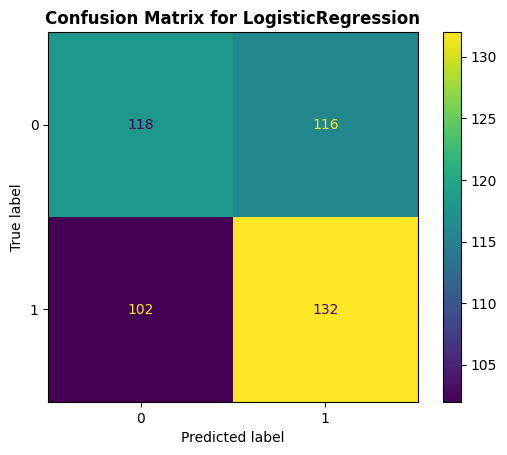

.......................................................


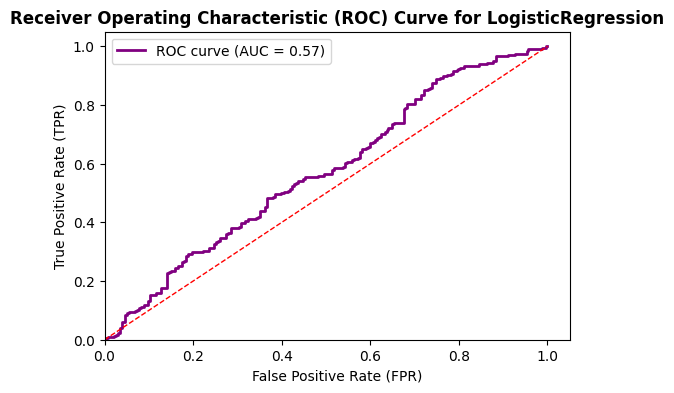

Note for AUC: A higher AUC indicates better performance.
.......................................................


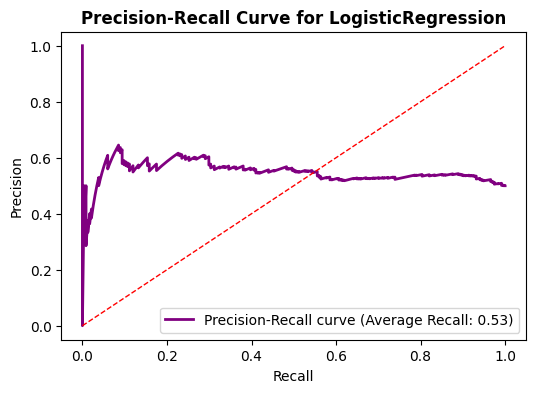

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_lr, y_val_lr, y_val_pred_lr, y_val_prob_lr)

##### K-Nearest Neighbours (KNN) Classifier

<Figure size 500x500 with 0 Axes>

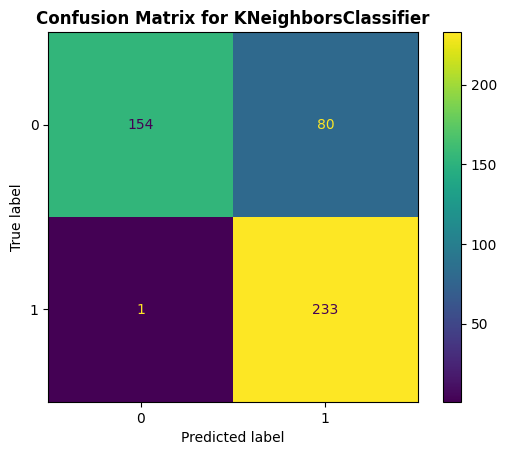

.......................................................


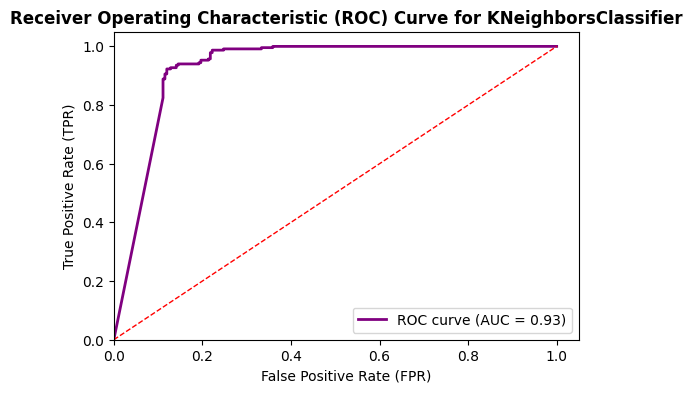

Note for AUC: A higher AUC indicates better performance.
.......................................................


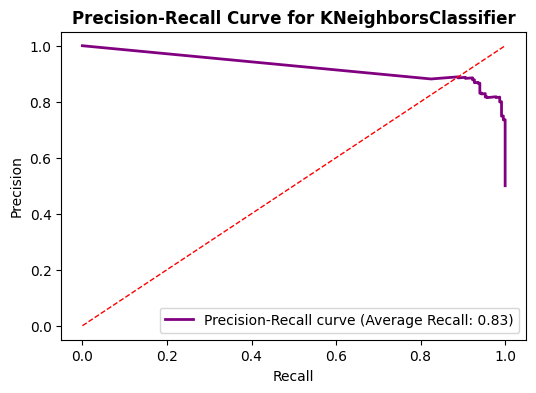

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_knn, y_val_knn, y_val_pred_knn, y_val_prob_knn)

##### Naive Bayes Classifier

<Figure size 500x500 with 0 Axes>

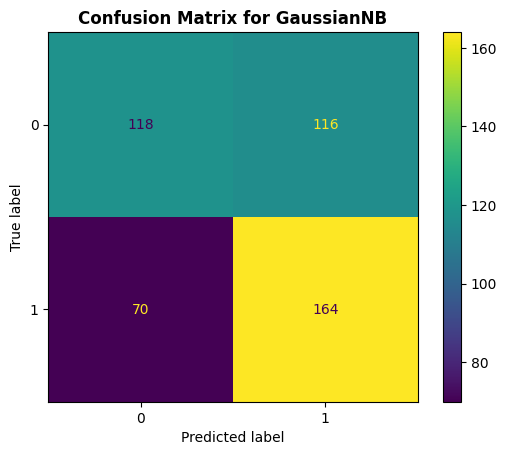

.......................................................


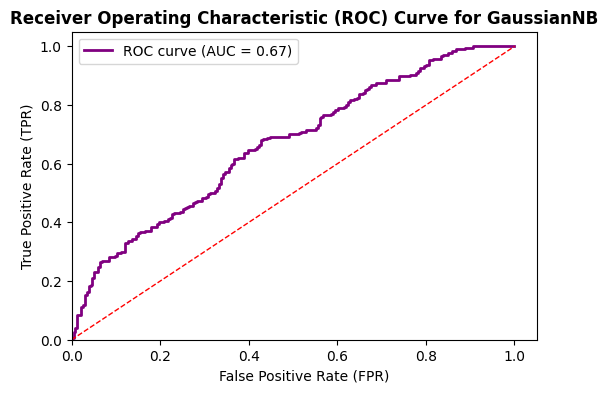

Note for AUC: A higher AUC indicates better performance.
.......................................................


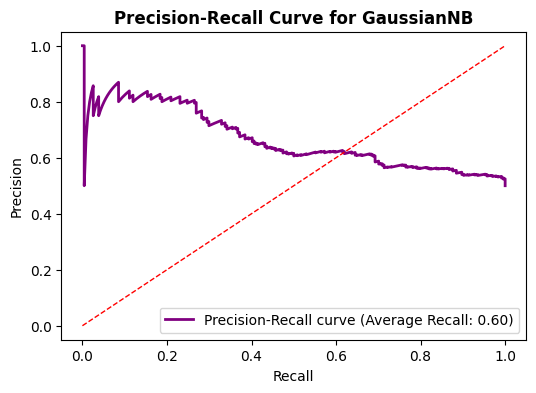

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_nb, y_val_nb, y_val_pred_nb, y_val_prob_nb)

##### eXtreme Gradient Boosting Classifier

<Figure size 500x500 with 0 Axes>

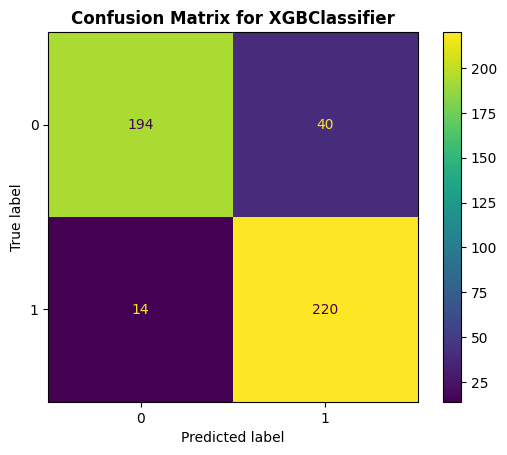

.......................................................


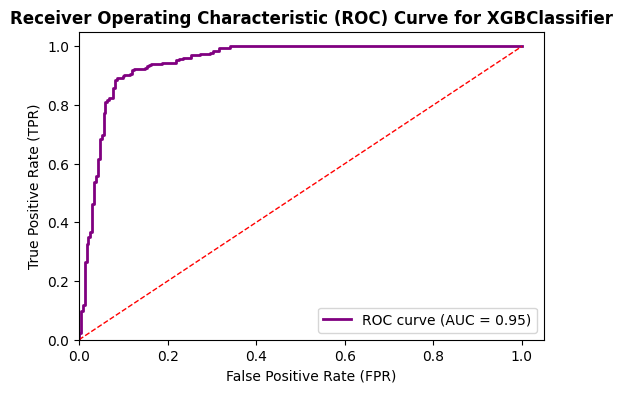

Note for AUC: A higher AUC indicates better performance.
.......................................................


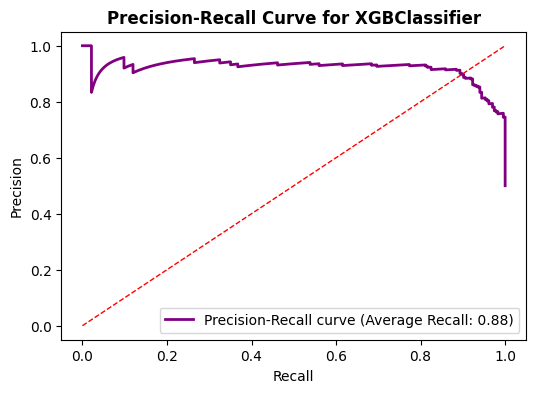

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_xgb, y_val_xgb, y_val_pred_xgb, y_val_prob_xgb)

##### Random Forest Classifier (Bagging based)

<Figure size 500x500 with 0 Axes>

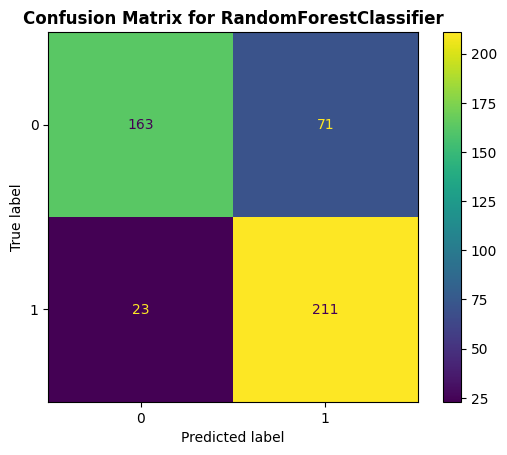

.......................................................


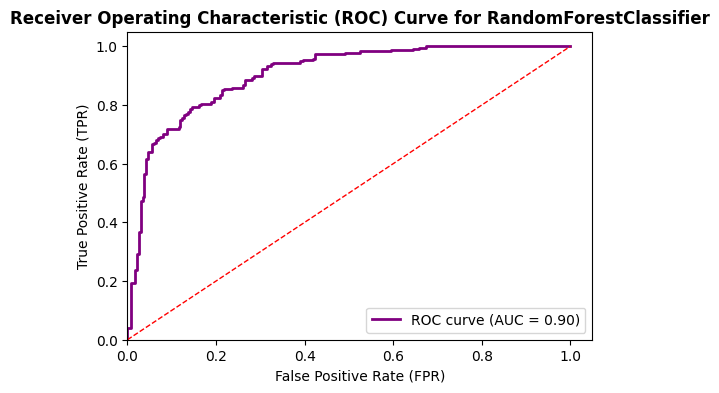

Note for AUC: A higher AUC indicates better performance.
.......................................................


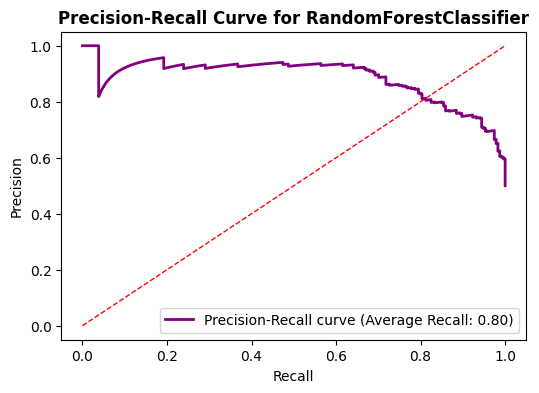

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_rf, y_val_rf, y_val_pred_rf, y_val_prob_rf)

##### Light Gradient Boosting Machine Classifier (Boosting based)

<Figure size 500x500 with 0 Axes>

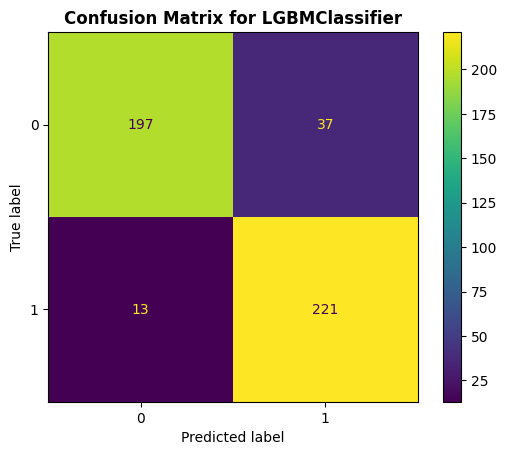

.......................................................


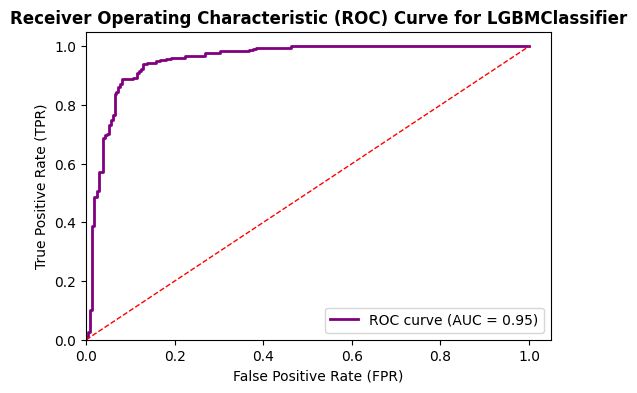

Note for AUC: A higher AUC indicates better performance.
.......................................................


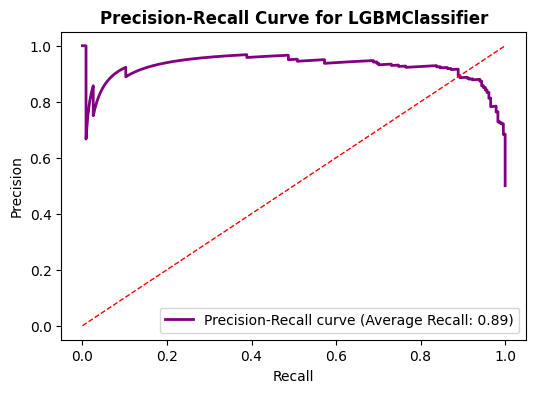

Note for Precision-Recall Curve: A curve closer to the top-right corner represents a good balance between precision and recall


In [ ]:
evaluate_model(tuned_lgb, y_val_lgb, y_val_pred_lgb, y_val_prob_lgb)

#### Observation:
**eXtreme Gradient Boosting Classifier** and **Light Gradient Boosting Machine Classifier** appear to have learnt the patterns in the data better than the rest.

# Stage 4: MODEL TESTING <a id="section-five"></a>
#### Objectives:
- Creating functions for model testing and evaluation.
- Testing the models.

### A function for model testing and evaluation
Variables to be used:
- X_test: "X_test_pca"
- y_test: "y_test"

In [ ]:
#Model evaluation
def evaluate_test_model(final_model, y_test, y_test_pred, y_test_prob):

    #Statistical Results for the test set
    print("TEST SET RESULTS:")
    print("." * 55)
    print(f"Classification Report:\n{metrics.classification_report(y_test, y_test_pred)}")
    print("." * 55)
    print(f"Accuracy: {metrics.accuracy_score(y_test, y_test_pred):.2f}")
    print(f"Precision: {metrics.precision_score(y_test, y_test_pred):.2f}")
    print(f"Recall: {metrics.recall_score(y_test, y_test_pred):.2f}")
    print(f"F1 Score (Harmonic mean of precision and recall): {metrics.f1_score(y_test, y_test_pred):.2f}")
    print("." * 55)
    print("\n")

    #Confusion Matrix for the test set
    cm = metrics.confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,5))
    cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_plot.plot()
    plt.title(f'Confusion Matrix for {type(final_model).__name__} Classifier', fontweight='bold')
    plt.show()
    print("." * 55)
    print("\n")

    return None

### Testing and evaluating the models

##### Logistic Regression

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.52      0.67       293
           1       0.07      0.52      0.13        21

    accuracy                           0.52       314
   macro avg       0.51      0.52      0.40       314
weighted avg       0.88      0.52      0.63       314

.......................................................
Accuracy: 0.52
Precision: 0.07
Recall: 0.52
F1 Score (Harmonic mean of precision and recall): 0.13
.......................................................




<Figure size 500x500 with 0 Axes>

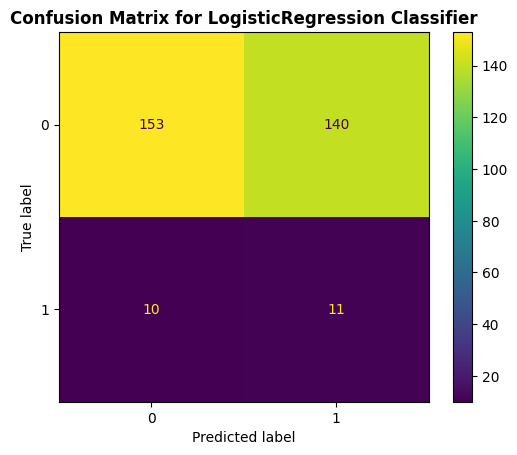

.......................................................




In [ ]:
y_test_pred_lr = tuned_lr.predict(X_test_pca)
y_test_prob_lr = tuned_lr.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_lr, y_test, y_test_pred_lr, y_test_prob_lr)

##### K-Nearest Neighbours (KNN) Classifier

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.71      0.81       293
           1       0.10      0.43      0.16        21

    accuracy                           0.69       314
   macro avg       0.52      0.57      0.48       314
weighted avg       0.89      0.69      0.77       314

.......................................................
Accuracy: 0.69
Precision: 0.10
Recall: 0.43
F1 Score (Harmonic mean of precision and recall): 0.16
.......................................................




<Figure size 500x500 with 0 Axes>

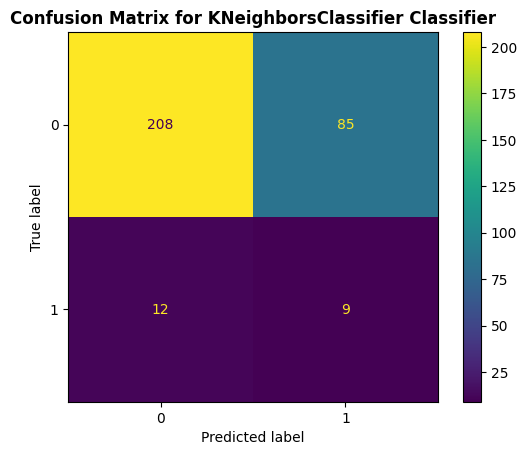

.......................................................




In [ ]:
y_test_pred_knn = tuned_knn.predict(X_test_pca)
y_test_prob_knn = tuned_knn.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_knn, y_test, y_test_pred_knn, y_test_prob_knn)

##### Naive Bayes Classifier

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.50      0.65       293
           1       0.06      0.43      0.10        21

    accuracy                           0.50       314
   macro avg       0.49      0.47      0.38       314
weighted avg       0.87      0.50      0.61       314

.......................................................
Accuracy: 0.50
Precision: 0.06
Recall: 0.43
F1 Score (Harmonic mean of precision and recall): 0.10
.......................................................




<Figure size 500x500 with 0 Axes>

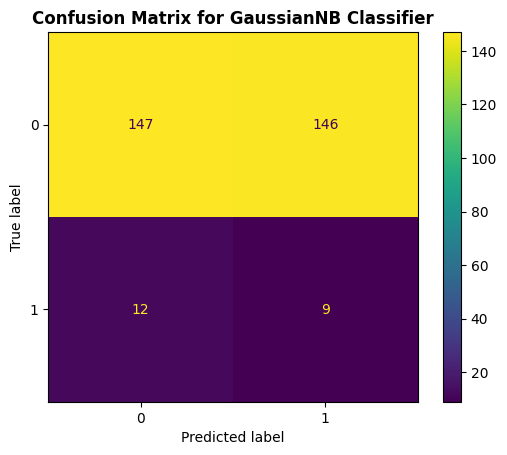

.......................................................




In [ ]:
y_test_pred_nb = tuned_nb.predict(X_test_pca)
y_test_prob_nb = tuned_nb.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_nb, y_test, y_test_pred_nb, y_test_prob_nb)

##### eXtreme Gradient Boosting Classifier

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       293
           1       0.08      0.14      0.10        21

    accuracy                           0.83       314
   macro avg       0.51      0.51      0.50       314
weighted avg       0.88      0.83      0.85       314

.......................................................
Accuracy: 0.83
Precision: 0.08
Recall: 0.14
F1 Score (Harmonic mean of precision and recall): 0.10
.......................................................




<Figure size 500x500 with 0 Axes>

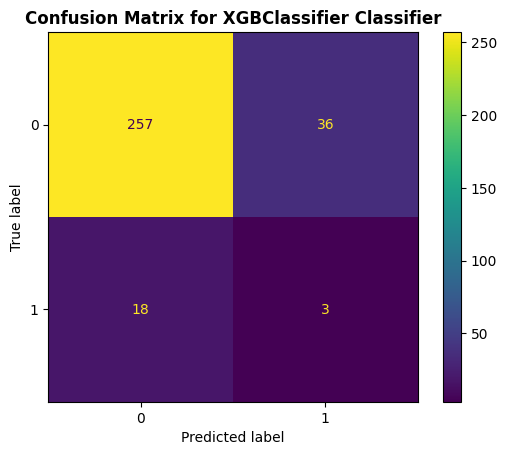

.......................................................




In [ ]:
y_test_binary = (y_test + 1) // 2

y_test_pred_xgb = tuned_xgb.predict(X_test_pca)
y_test_prob_xgb = tuned_xgb.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_xgb, y_test_binary, y_test_pred_xgb, y_test_prob_xgb)

##### Random Forest Classifier (Bagging based)

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.74      0.83       293
           1       0.07      0.29      0.12        21

    accuracy                           0.71       314
   macro avg       0.50      0.51      0.47       314
weighted avg       0.88      0.71      0.78       314

.......................................................
Accuracy: 0.71
Precision: 0.07
Recall: 0.29
F1 Score (Harmonic mean of precision and recall): 0.12
.......................................................




<Figure size 500x500 with 0 Axes>

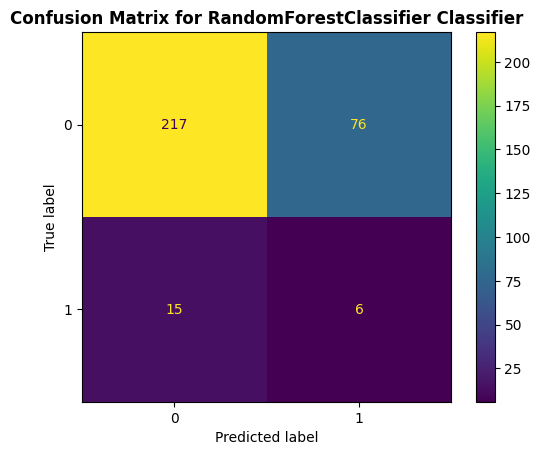

.......................................................




In [ ]:
y_test_pred_rf = tuned_rf.predict(X_test_pca)
y_test_prob_rf = tuned_rf.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_rf, y_test, y_test_pred_rf, y_test_prob_rf)

##### Light Gradient Boosting Machine Classifier (Boosting based)

TEST SET RESULTS:
.......................................................
Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.89      0.91       293
           1       0.03      0.05      0.04        21

    accuracy                           0.83       314
   macro avg       0.48      0.47      0.47       314
weighted avg       0.87      0.83      0.85       314

.......................................................
Accuracy: 0.83
Precision: 0.03
Recall: 0.05
F1 Score (Harmonic mean of precision and recall): 0.04
.......................................................




<Figure size 500x500 with 0 Axes>

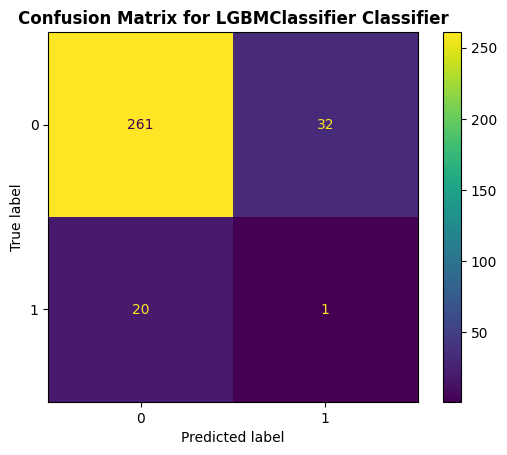

.......................................................




In [ ]:
y_test_pred_lgb = tuned_lgb.predict(X_test_pca)
y_test_prob_lgb = tuned_lgb.predict_proba(X_test_pca)[:,1]
evaluate_test_model(tuned_lgb, y_test, y_test_pred_lgb, y_test_prob_lgb)

# CONCLUSION <a id="section-six"></a>
Although the models appear to struggle to predict the class '1' (Fail) well, upon evaluating the performance on the testing set, the **K-Nearest Neighbours (KNN) Classifier** appears to have performed better than others. Hence, for the current scenario, I'll select the same as the final model of choice.

In [ ]:
#Exporting the selected model using Pickle
with open('semiconductors_knn.pkl', 'wb') as file:
    pickle.dump(tuned_knn, file)

<center> -- Thank You --</center>